大多数MLC过程可以看作张量函数之间的转换，下面关注计算图之间的高层优化

In [1]:
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations
import numpy as np
import tvm
from tvm import relax, topi
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

下面看一个简单的例子

In [2]:
@tvm.script.ir_module
class MyModule:
    @R.function
    def main(x: Tensor((3, 4), "float32"), y: Tensor((3, 4), "float32")):
        with relax.dataflow():
            lv0 = relax.multiply(x, y)
            gv0 = relax.add(lv0, y)
            relax.output(gv0)
        return gv0

包含一个带有两个图层`op`的`relax`函数，其中包含`relax.multiply`和`relax.add`。我们的目标是找到这两个运算符并将它们替换为一个`relax.ewise_fma`运算符的调用

首先检查构成`MyModule`的数据结构。 每个`IRModule`都包含一组函数，函数体由一组称为抽象语法树（AST）的数据结构组成

In [3]:
relax_func = MyModule["main"]

In [4]:
type(relax_func)

tvm.relax.expr.Function

In [5]:
relax_func.params

[relax.expr.Var(0x27bc180), relax.expr.Var(0x27c8ed0)]

函数包含一个返回值表达式，和函数中的一组binding blocks

In [6]:
func_body = relax_func.body
type(func_body)

tvm.relax.expr.SeqExpr

In [7]:
func_body.blocks

[relax.expr.DataflowBlock(0x278cde0)]

In [8]:
dataflow_block = func_body.blocks[0]

数据流块有两个binding，对于`lv0`和`gv0`

In [9]:
dataflow_block.bindings

[relax.expr.VarBinding(0x2842ed0), relax.expr.VarBinding(0x28436d0)]

In [10]:
binding = dataflow_block.bindings[0]

每个binding都有一个对应于绑定左侧的var(lv0, gv0)，并且每个binding的右侧是他的value，每个value对应一个relax.Call节点，表示对元函数的调用

In [11]:
binding.value

CallNode(Op(relax.multiply), [relax.expr.Var(0x27bc180), relax.expr.Var(0x27c8ed0)], (nullptr), [])

改写程序可以通过递归遍历`MyModule`的`AST`，并生成转换后的`AST`来实现。我们当然可以直接使用构建AST的`python API`来做到这一点。但是，我们可以使用额外的工具支持来简化流程。下面的代码块遵循一种称为访问者模式(visitor pattern)的设计模式，它允许我们访问每个`AST`节点并将它们重写为转换后的版本

In [14]:
@relax.expr_functor.mutator
class EwiseFMARewriter(relax.PyExprMutator):
    def visit_call_(self, call):
        call = self.visit_expr_post_order(call)
        add_op = tvm.ir.Op.get("relax.add")
        multiply_op = tvm.ir.Op.get("relax.multiply")
        ewise_fma_op = tvm.ir.Op.get("relax.ewise_fma")

        if call.op != add_op:
            return call

        value = self.lookup_binding(call.args[0])
        if not isinstance(value, relax.Call) or value.op != multiply_op:
            return call

        fma_call = relax.Call(
            ewise_fma_op, [value.args[0], value.args[1], call.args[1]], None, None
        )
        return fma_call


updated_fn = EwiseFMARewriter().visit_expr(MyModule["main"])
updated_fn.show()

结果将`gv01`重写为融合运算符，但将`lv0`留在代码中。我们可以使用`remove_all_unused`来进一步简化代码块

In [15]:
relax.analysis.remove_all_unused(updated_fn).show()

下面尝试在端到端模型上进行尝试

In [16]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))

In [17]:
def create_model():
    bb = relax.BlockBuilder()
    x = relax.Var("x", (1, 784), relax.DynTensorType(2, "float32"))
    w0 = relax.const(mlp_params["w0"], "float32")
    b0 = relax.const(mlp_params["b0"], "float32")
    w1 = relax.const(mlp_params["w1"], "float32")
    b1 = relax.const(mlp_params["b1"], "float32")

    with bb.function("main", [x]):
        with bb.dataflow():
            lv0 = bb.emit(relax.op.dense(x, w0))
            lv1 = bb.emit(relax.op.add(lv0, b0))
            lv2 = bb.emit(relax.op.relu(lv1))
            lv3 = bb.emit(relax.op.dense(lv2, w1))
            lv4 = bb.emit(relax.op.add(lv3, b1))
            gv = bb.emit_output(lv4)
        bb.emit_func_output(gv)

    return bb.get()

MLPModel = create_model()
MLPModel.show()

目标是“融合”dense和add算子到一起，以下代码通过以下步骤实现：
+ 识别dense和add算法
+ 生成另一个调用dense和add算子的子函数
+ 将dense和add替换为融合后的子函数

In [19]:
@relax.expr_functor.mutator
class DenseAddFusor(relax.PyExprMutator):
    def __init__(self, mod: IRModule) -> None:
        super().__init__()
        self.mod_ = mod
        # cache pre-defined ops
        self.add_op = tvm.ir.Op.get("relax.add")
        self.dense_op = tvm.ir.Op.get("relax.nn.dense")
        self.counter = 0

    def transform(self) -> IRModule:
        for global_var, func in self.mod_.functions.items():
            if not isinstance(func, relax.Function):
                continue
            # avoid already fused primitive functions
            if "Primitive" in func.attrs.keys() and func.attrs["Primitive"] != 0:
                continue
            updated_func = self.visit_expr(func)
            updated_func = relax.analysis.remove_all_unused(updated_func)
            self.builder_.update_func(global_var, updated_func)

        return self.builder_.get()

    def visit_call_(self, call):
        call = self.visit_expr_post_order(call)

        def match_call(node, op):
            if not isinstance(node, relax.Call):
                return False
            return node.op == op

        # pattern match dense => add
        if not match_call(call, self.add_op):
            return call

        value = self.lookup_binding(call.args[0])
        if value is None:
            return call

        if not match_call(value, self.dense_op):
            return call

        x = value.args[0]
        w = value.args[1]
        b = call.args[1]

        # construct a new fused primitive function
        param_x = relax.Var("x", x.shape_, x._checked_type_)
        param_w = relax.Var("w", w.shape_, w._checked_type_)
        param_b = relax.Var("b", b.shape_, b._checked_type_)

        bb = relax.BlockBuilder()

        fn_name = "fused_dense_add%d" % (self.counter)
        self.counter += 1
        with bb.function(fn_name, [param_x, param_w, param_b]):
            with bb.dataflow():
                lv0 = bb.emit(relax.op.nn.dense(param_x, param_w))
                gv = bb.emit_output(relax.op.add(lv0, param_b))
            bb.emit_func_output(gv)

        # Add Primitive attribute to the fused funtions
        fused_fn = bb.get()[fn_name].with_attr("Primitive", 1)
        global_var = self.builder_.add_func(fused_fn, fn_name)

        # construct call into the fused function
        return relax.Call(global_var, [x, w, b], None, None)

@tvm.ir.transform.module_pass(opt_level=2, name="DeseAddFuse")
class FuseDenseAddPass:
    """The wrapper for the LowerTensorIR pass."""
    def transform_module(self, mod, ctx):
        return DenseAddFusor(mod).transform()


MLPFused = FuseDenseAddPass()(MLPModel)
MLPFused.show()

在上面的例子中，我们创建了两个前缀为`fuse_dense_add`的子函数。这些子函数包含有融合后算子的计算信息。这种重写的替代方法是简单地为融合运算符创建一个单独的原始操作（如ewise_fma）。但是，当我们尝试融合更多运算符时，可能存在指数级数量的组合。将融合操作分组在一起的子函数为后续的`pass`保留了原始信息，进而便于分析，无需为每个融合`pattern`引入专用的高级运算符

融合后的`IRModule`仅包含对图层`op`的调用。 为了进一步进行底层优化和代码生成，我们需要将这些高级原语运算转换为相应的`TensorIR`函数（或调用库函数）。

以下代码将图层算子重新映射到相应的`TensorIR`函数。 在这里，我们利用`Mutator`中的内部`block builder`并使用`call_te`返回转换后的值

In [20]:
@relax.expr_functor.mutator
class LowerToTensorIR(relax.PyExprMutator):
    def __init__(self, mod: IRModule, op_map) -> None:
        super().__init__()
        self.mod_ = mod
        self.op_map = {
            tvm.ir.Op.get(k): v for k, v in op_map.items()
        }


    def visit_call_(self, call):
        call = self.visit_expr_post_order(call)

        if call.op in self.op_map:
            return self.op_map[call.op](self.builder_, call)
        return call

    def transform(self) -> IRModule:
        for global_var, func in self.mod_.functions.items():
            if not isinstance(func, relax.Function):
                continue
            updated_func = self.visit_expr(func)
            self.builder_.update_func(global_var, updated_func)

        return self.builder_.get()


def map_dense(bb, call):
    x, w = call.args
    return bb.call_te(topi.nn.dense, x, w)

def map_add(bb, call):
    a, b = call.args
    return bb.call_te(topi.add, a, b)

def map_relu(bb, call):
    return bb.call_te(topi.nn.relu, call.args[0])


op_map = {
  "relax.nn.dense": map_dense,
  "relax.add": map_add,
  "relax.nn.relu": map_relu
}

@tvm.ir.transform.module_pass(opt_level=0, name="LowerToTensorIR")
class LowerToTensorIRPass:
    """The wrapper for the LowerTensorIR pass."""
    def transform_module(self, mod, ctx):
        return LowerToTensorIR(mod, op_map).transform()


MLPModelTIR = LowerToTensorIRPass()(MLPFused)
MLPModelTIR.show()

请注意，在上面的代码中。`fused_dense_add0`和`fused_dense_add1`仍然是上层`relax`函数，它们调用相应的`TensorIR dense`和`add`函数。 我们可以将它们变成一个单一的`TensorIR`函数，然后可以用于后续优化和代码生成阶段

In [21]:
MLPModelFinal = relax.transform.FuseTIR()(MLPModelTIR)
MLPModelFinal.show()

In [22]:
# Hide outputs
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

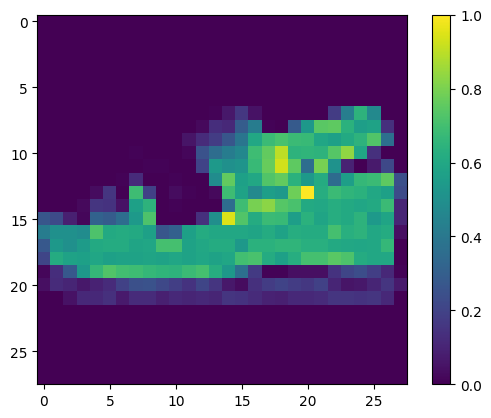

Class: Sandal


In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [24]:
ex = relax.vm.build(MLPModelFinal, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())
data_nd = tvm.nd.array(img.reshape(1, 784))

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MLPModule Prediction:", class_names[pred_kind[0]])

MLPModule Prediction: Sandal
